# Lifestyle inflation


In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("fivethirtyeight")

sys.path.insert(0, "utils.py")
import utils

### Define our functions needed

In [2]:
def plot_amount(df: pd.DataFrame, *args, **kwargs) -> None:
    """
    Plot the amount in and out for a given column.
    """
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15, 5))
    title = kwargs.get("title")
    style = kwargs.get("style")
    [df[cname].plot(ax=ax, label=cname, style=style) for cname in args]

    ax.legend(args)
    ax.set_title(title)
    plt.show()

In [3]:
def print_correlation(df: pd.DataFrame, *column_names) -> None:
    correlation_dict = {
        "No relationship": [0, 0.25],
        "Weak relationship": [0.25, 0.5],
        "Moderate relationship": [0.5, 0.75],
        "Strong relationship": [0.75, 1],
    }

    # Calculate the correlation between the two columns
    correlation = df.corrwith(df[column_names[0]])[column_names[1]]
    print(f"Correlation: {column_names[0]} vs {column_names[1]}:", correlation)

    for relationship, num_range in correlation_dict.items():
        if num_range[0] < abs(correlation) < num_range[1]:
            print(f"Correlation is a {relationship}")
            break

### Read data from csv file and store into dataframe

In [4]:
### Create checking data ###
df_checkings = utils.combine_dfs("Bank_Data", "checkings.csv")
df_checkings = df_checkings.set_index("Posting Date")
df_checkings.index = pd.to_datetime(df_checkings.index)

### Inspect the data

In [5]:
df_checkings.head()

,Details,Amount,Type,Balance,Check or Slip #
Posting Date,,,,,
2010-01-01,DEBIT,-79.0,DEBIT_CARD,813.46,NaN
2010-01-02,DEBIT,-799.0,ACCT_XFER,13.46,NaN
2010-01-03,DEBIT,0.0,ACCT_XFER,13.46,NaN
2010-01-04,DEBIT,0.0,ACCT_XFER,13.46,NaN
2010-01-05,DEBIT,0.0,ACCT_XFER,13.46,NaN


### Remove unnecessary columns

In [6]:
# Remove unnecessary columns and rename columns
df_checkings = df_checkings.drop(columns=["Check or Slip #", "Type", "Details"])
df_checkings = df_checkings.rename(columns={"Amount": "amount", "Balance": "balance"})
df_checkings.index.name = "date"
df_checkings.head()

,amount,balance
date,,
2010-01-01,-79.0,813.46
2010-01-02,-799.0,13.46
2010-01-03,0.0,13.46
2010-01-04,0.0,13.46
2010-01-05,0.0,13.46


### `Amount` Column
- Consists of positive and negative floating point numbers. 
- Negative numbers indicate payments/withdrawals and positive numbers indicate amount_ins.
- Create two new columns: `amount_in` and `amount_out` to separate the positive and negative numbers.


In [7]:
df_checkings["amount_out"] = df_checkings["amount"].apply(lambda x: abs(min(x, 0)))
df_checkings["amount_in"] = df_checkings["amount"].apply(lambda x: abs(max(x, 0)))

### Inspect the new data

In [8]:
df_checkings.head()

,amount,balance,amount_out,amount_in
date,,,,
2010-01-01,-79.0,813.46,79.0,0.0
2010-01-02,-799.0,13.46,799.0,0.0
2010-01-03,0.0,13.46,0.0,0.0
2010-01-04,0.0,13.46,0.0,0.0
2010-01-05,0.0,13.46,0.0,0.0


### Normalize the data

In [9]:
def get_min_max(df: pd.DataFrame, *column_names) -> tuple:
    column_list = [df[cname].to_list() for cname in column_names]
    column_list = np.ndarray.flatten(np.array(column_list))
    return min(column_list), max(column_list)


def normalize(
    df: pd.DataFrame, _min: float, _max: float, *column_names
) -> pd.DataFrame:
    """
    Normalize a column in a dataframe.
    """
    df = df.copy()

    for cname in column_names:
        df[f"{cname}_norm"] = (df_checkings[cname] - _min) / (_max - _min)
    return df


_min, _max = get_min_max(df_checkings, "balance", "amount_in", "amount_out")
df_checkings = normalize(df_checkings, _min, _max, "balance", "amount_in", "amount_out")

df_checkings.head()
df_checkings = df = df_checkings[
    [
        "amount",
        "balance",
        "balance_norm",
        "amount_in",
        "amount_in_norm",
        "amount_out",
        "amount_out_norm",
    ]
]

### Create `amount_df`

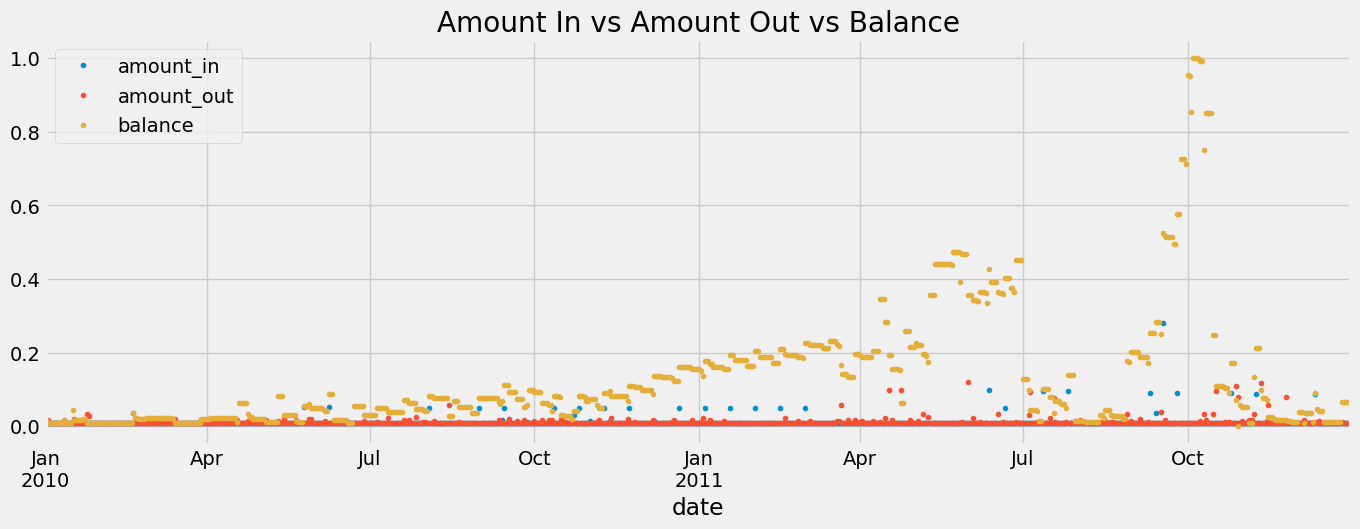

In [10]:
amount_df = pd.DataFrame()
amount_df["amount_in"] = df_checkings["amount_in_norm"]
amount_df["amount_out"] = df_checkings["amount_out_norm"]
amount_df["balance"] = df_checkings["balance_norm"]

plot_amount(
    amount_df,
    "amount_in",
    "amount_out",
    "balance",
    title="Amount In vs Amount Out vs Balance",
    style=".",
)

# There are too many zeros in the `amount_in` and `amount_out` columns.
- Remove the rows with zeros in both the columns and store the cleaned values in `amount_in_cleaned` & `amount_out_cleaned` respectively.
- These columns will be used to plot the data.

In [11]:
# because we can have negative balances in our account (which are valid data points), a zero
# value to not get normalized to zero. We need to know what zero gets normalized to.
# Find a row where amount_in is zero and get the normalized value
zero_norm = df_checkings[df_checkings["amount_in"] == 0]
zero_norm = zero_norm["amount_in_norm"].to_list()[0]

amount_df["amount_in_cleaned"] = amount_df[amount_df["amount_in"] > zero_norm][
    "amount_in"
]
amount_df["amount_out_cleaned"] = amount_df[amount_df["amount_out"] > zero_norm][
    "amount_out"
]

amount_df["balance_cleaned"] = amount_df[amount_df["balance"] > zero_norm]["balance"]

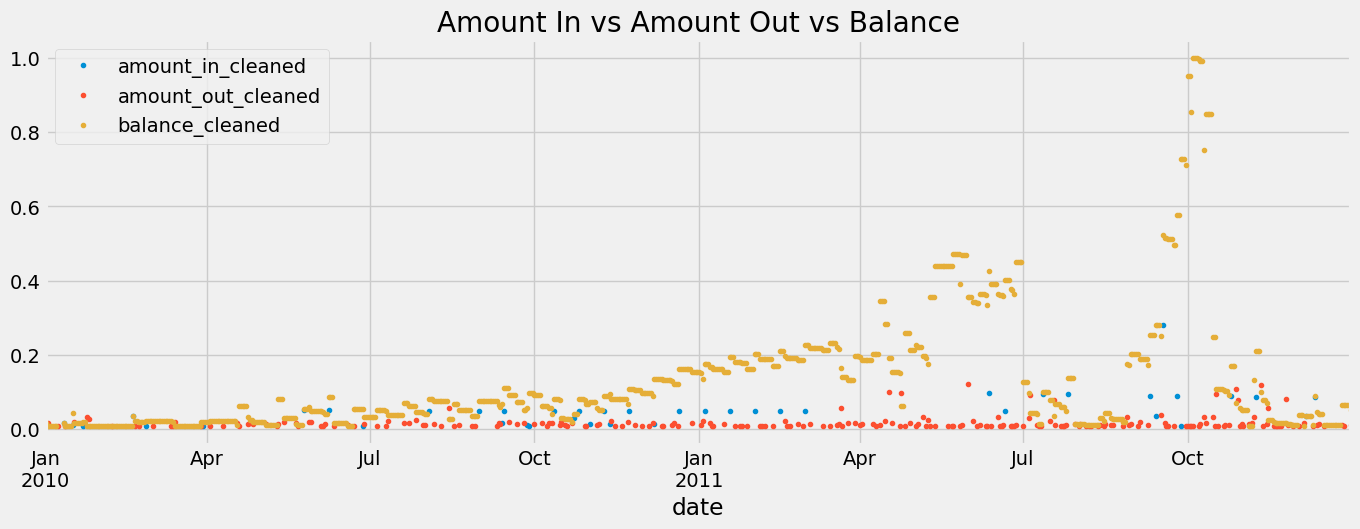

In [12]:
plot_amount(
    amount_df,
    "amount_in_cleaned",
    "amount_out_cleaned",
    "balance_cleaned",
    title="Amount In vs Amount Out vs Balance",
    style=".",
)

## Calculate Lifestyle Inflation
- Is there a correlation between the amount of money coming in and the amount going out?
- Calculate the correlation between `amount_in` and `amount_out`

In [13]:
# Create a general correlation matrix
amount_df.corr()

,amount_in,amount_out,balance,amount_in_cleaned,amount_out_cleaned,balance_cleaned
amount_in,1.000000,-0.039807,0.103497,1.000000,NaN,0.102986
amount_out,-0.039807,1.000000,-0.008390,NaN,1.000000,-0.002661
balance,0.103497,-0.008390,1.000000,0.468192,-0.060446,1.000000
amount_in_cleaned,1.000000,NaN,0.468192,1.000000,NaN,0.468192
amount_out_cleaned,NaN,1.000000,-0.060446,NaN,1.000000,-0.052001
balance_cleaned,0.102986,-0.002661,1.000000,0.468192,-0.052001,1.000000


In [14]:
print_correlation(amount_df, "amount_in", "amount_out")

Correlation: amount_in vs amount_out: -0.03980727073072738
Correlation is a No relationship


## So the two columns aren't correlated...right? 
- Take the rolling average between the two columns and plot it.

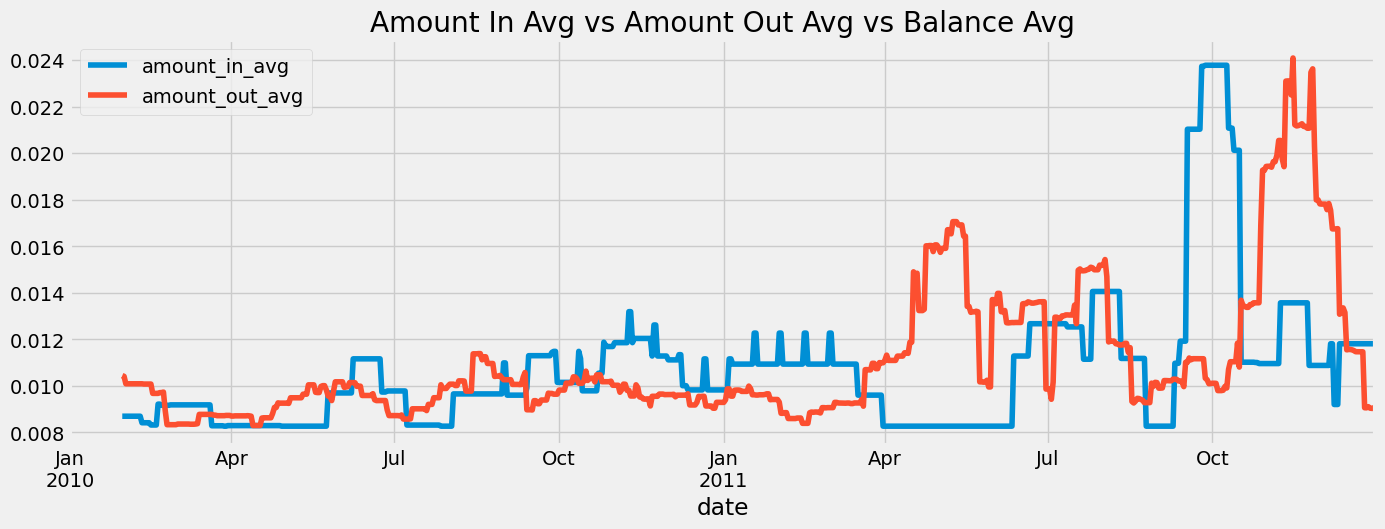

In [15]:
# Take the rolling mean of the two columns
WINDOW = 30

amount_df["amount_in_avg"] = amount_df["amount_in"].rolling(window=WINDOW).mean()
amount_df["amount_out_avg"] = amount_df["amount_out"].rolling(window=WINDOW).mean()
plot_amount(
    amount_df,
    "amount_in_avg",
    "amount_out_avg",
    style="-",
    title="Amount In Avg vs Amount Out Avg vs Balance Avg",
)

# There appear to be some correlations between the two columns.
- Let's see if we can mathematically prove it.
- Calculate the correlation coefficient between the two columns.
- Try to align the `amount_in_avg` and `amount_out_avg` columns by shifting the `amount_in_avg` by `WINDOW` days plus the `SHIFT` value.

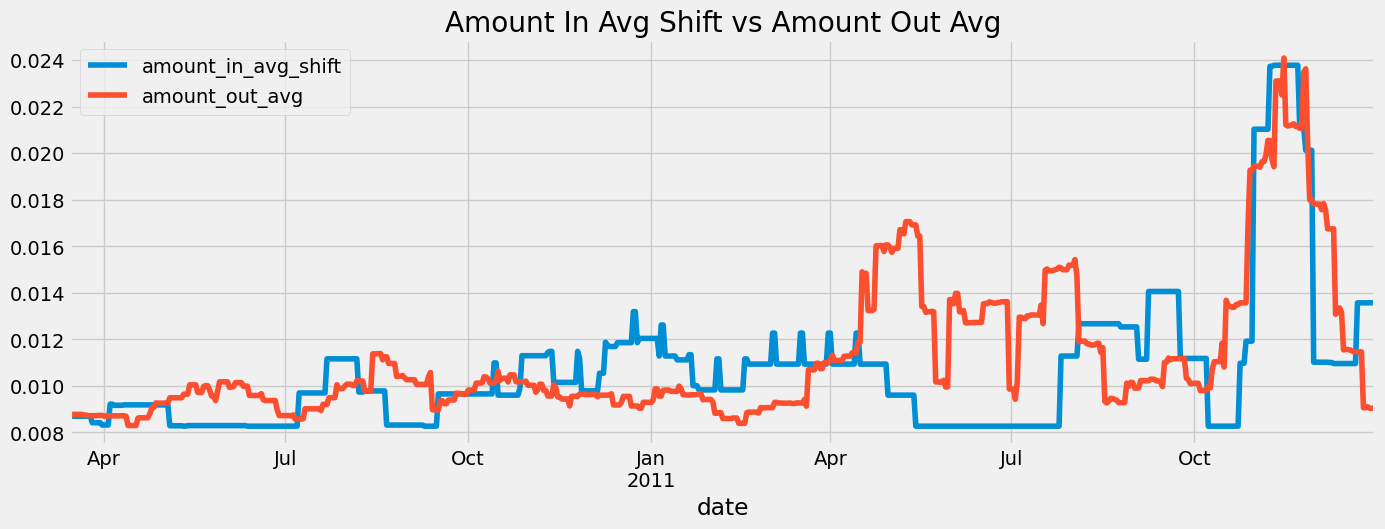

In [16]:
SHIFT = 14

# shift the amount_in avg column
amount_df["amount_in_avg_shift"] = amount_df["amount_in_avg"].shift(WINDOW + SHIFT)

# # however you choose to shift, make sure you remove the NaNs
amount_df = amount_df[amount_df["amount_in_avg_shift"].notnull()]

plot_amount(
    amount_df,
    "amount_in_avg_shift",
    "amount_out_avg",
    style="-",
    title="Amount In Avg Shift vs Amount Out Avg",
)

In [17]:
amount_df.corr()

,amount_in,amount_out,balance,amount_in_cleaned,amount_out_cleaned,balance_cleaned,amount_in_avg,amount_out_avg,amount_in_avg_shift
amount_in,1.000000,-0.041940,0.096278,1.000000,NaN,0.096114,0.173560,0.024948,0.051067
amount_out,-0.041940,1.000000,-0.020334,NaN,1.000000,-0.013287,0.001920,0.258262,0.107750
balance,0.096278,-0.020334,1.000000,0.421412,-0.068338,1.000000,0.591248,0.022345,-0.071906
amount_in_cleaned,1.000000,NaN,0.421412,1.000000,NaN,0.421412,0.433156,0.313802,0.316053
amount_out_cleaned,NaN,1.000000,-0.068338,NaN,1.000000,-0.057719,-0.041398,0.287274,0.098749
balance_cleaned,0.096114,-0.013287,1.000000,0.421412,-0.057719,1.000000,0.591630,0.025938,-0.071405
amount_in_avg,0.173560,0.001920,0.591248,0.433156,-0.041398,0.591630,1.000000,0.104058,0.210428
amount_out_avg,0.024948,0.258262,0.022345,0.313802,0.287274,0.025938,0.104058,1.000000,0.585000
amount_in_avg_shift,0.051067,0.107750,-0.071906,0.316053,0.098749,-0.071405,0.210428,0.585000,1.000000


In [18]:
print_correlation(amount_df, "amount_in_avg_shift", "amount_out_avg")

Correlation: amount_in_avg_shift vs amount_out_avg: 0.5849996701627177
Correlation is a Moderate relationship


## Yikes! Lifestyle Inflation is real!


# Questions
- Can I shift the values and still calculate the correlation coefficient?
- Is there a better way to calculate the correlation coefficient? 